<a href="https://colab.research.google.com/github/shikhargoswami/Cars24_Assessment/blob/main/Case_Study_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Outline

* Downloading Dataset(MNIST)
* Dataloader in torch.utils
* Visualizing images
* Convolution Layers

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Data Loading

We will use torchvision.datasets to get **MNIST** dataset. The dataset contains 70,000 28x28 grayscale images of handwritten digits of which 60,000 are training images and 10,000 are test images.

In [2]:
import torchvision
import torchvision.transforms as transforms
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [4]:
classes = ('0','1', '2', '3', '4', '5', '6', '7', '8', '9')

In [5]:
dataiter = iter(trainloader) # Accessing the trainloader
images, labels = dataiter.next() #One batch of 4 images

print(images.shape)

print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
1


We can see the dimesions of image tensor is (batch_size, channels, x, y)

# Visualize data

Checking class imabalance

In [6]:
idx2class = {v: k for k, v in trainset.class_to_idx.items()}

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [7]:
print("Distribution of classes: \n", get_class_distribution(trainset))

Distribution of classes: 
 {'0 - zero': 5923, '1 - one': 6742, '2 - two': 5958, '3 - three': 6131, '4 - four': 5842, '5 - five': 5421, '6 - six': 5918, '7 - seven': 6265, '8 - eight': 5851, '9 - nine': 5949}


Text(0.5, 1.0, 'MNIST Class Distribution')

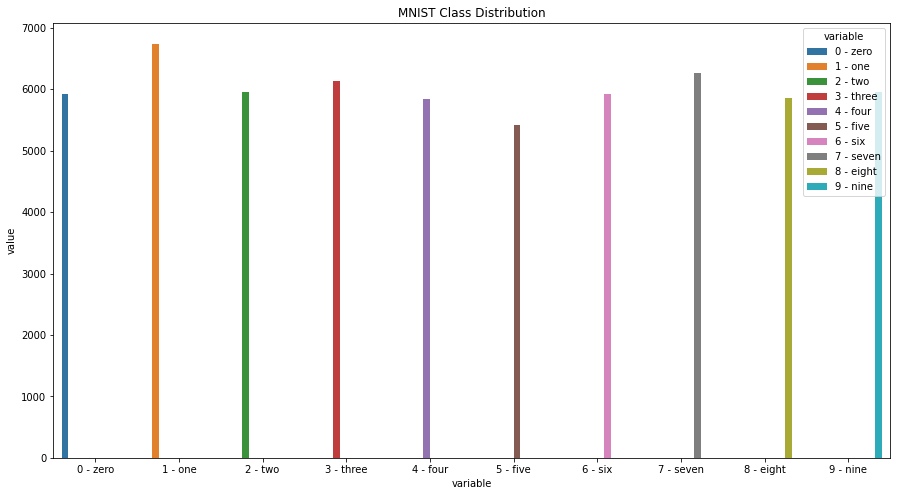

In [8]:
plt.figure(figsize=(15,8))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(trainset)]).melt(), x = "variable", y="value", hue="variable").set_title('MNIST Class Distribution')

We can see that the dataset is almost balanced. Hence, choosing accuracy as metric seems reasonable.

In [9]:
img = images[0]
print(type(img))

<class 'torch.Tensor'>


We need to convert the image tensor into numpy image to be able to plot it. Also, we need to change the dimesions **(channels, x, y) -> (x,y,channels)**

In [10]:
npimg = img.numpy()
npimg = np.transpose(npimg, (1, 2, 0))
print(npimg.shape)
npimg = np.squeeze(npimg)
print(npimg.shape)

(28, 28, 1)
(28, 28)


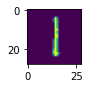

In [11]:
plt.figure(figsize=(1,1))
plt.imshow(npimg)
plt.show()

In [12]:
# helper function
def imshow(img):
  npimg = img.numpy()
  npimg = np.transpose(npimg, (1,2,0))
  npimg = np.squeeze(npimg)
  plt.imshow(npimg)
  plt.show()

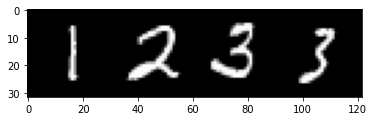

1 2 3 3


In [13]:
# Plotting images in a batch
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]]for j in range(4)))

# Single Convolution Layer

In [14]:
import torch.nn as nn

class FirstCNN(nn.Module):
  def __init__(self):
    super(FirstCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3) #16 kernels of 3x3 over each channel i.e 1 
  
  def forward(self, x):
    x = self.conv1(x)
    return x

In [15]:
net = FirstCNN()

In [16]:
out = net(images)
out.shape

torch.Size([4, 16, 26, 26])

In [17]:
for param in net.parameters():
  print(param.shape)

torch.Size([16, 1, 3, 3])
torch.Size([16])


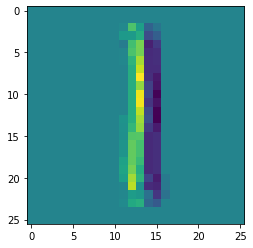

In [18]:
plt.imshow(out[0, 0, :, :].detach().numpy())
plt.show()

It's of images[0]which corresponded with label=1. We can see that with random initialization of parameters and no training, we are able to see some fetures of image is being preserved. Let's build CNN with classification layers.

# CNN + FFN

In [19]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.cnn_model = nn.Sequential(
        nn.Conv2d(1, 6, 3),   # (N, 1, 28, 28) -> (N, 6, 26, 26)
        nn.Tanh(),
        nn.MaxPool2d(2, stride=2),   # (N, 6, 26, 26) -> (N, 6, 14, 14)
        nn.Conv2d(6, 16, 3),        # (N, 6, 14, 14) -> (N, 16, 12, 12)
        nn.Tanh(),
        nn.MaxPool2d(2, stride=2)  # (N, 6, 12, 12) -> (N, 16, 6, 6)
    )

    self.fc_model = nn.Sequential(
        nn.Linear(400, 120),
        nn.Tanh(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84,10)
    )

  def forward(self, x):
    # print(x.shape)
    x = self.cnn_model(x)
    # print(x.shape)
    x = x.view(x.size(0), -1)
    # print(x.shape)
    x = self.fc_model(x)
    # print(x.shape)
    return x

In [20]:
net = Model()
out = net(images)

In [21]:
print(out)

tensor([[-0.0091,  0.0463, -0.0810, -0.0982,  0.1009, -0.0601,  0.0074,  0.1167,
          0.0538,  0.0379],
        [-0.0360,  0.0339, -0.0535, -0.1056,  0.0684, -0.0543,  0.0191,  0.1335,
          0.0866,  0.0353],
        [-0.0176,  0.0500, -0.0870, -0.1018,  0.1003, -0.0574,  0.0247,  0.1205,
          0.0884,  0.0267],
        [-0.0170,  0.0398, -0.0672, -0.0970,  0.1005, -0.0566,  0.0187,  0.1381,
          0.0919,  0.0234]], grad_fn=<AddmmBackward0>)


In [22]:
max_values, pred_class = torch.max(out.data, 1)
print(pred_class)

tensor([7, 7, 7, 7])


Right now, with random initialization the model is predicting all 4 images as 7

# Training on GPU

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
batch_size = 128
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [25]:
def evaluation(dataloader):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _,pred =  torch.max(outputs.data, 1)
    total+=labels.size(0)
    correct += (pred==labels).sum().item()
  return 100 * correct / total

In [26]:
net = Model().to(device)

In [27]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

Epoch: 0/16, Test acc: 96.70, Train acc: 96.32
Epoch: 1/16, Test acc: 97.85, Train acc: 98.03
Epoch: 2/16, Test acc: 98.56, Train acc: 98.61
Epoch: 3/16, Test acc: 98.46, Train acc: 98.82
Epoch: 4/16, Test acc: 98.72, Train acc: 99.08
Epoch: 5/16, Test acc: 98.71, Train acc: 99.37
Epoch: 6/16, Test acc: 98.74, Train acc: 99.26
Epoch: 7/16, Test acc: 98.70, Train acc: 99.51
Epoch: 8/16, Test acc: 98.69, Train acc: 99.58
Epoch: 9/16, Test acc: 98.90, Train acc: 99.70
Epoch: 10/16, Test acc: 98.91, Train acc: 99.62
Epoch: 11/16, Test acc: 98.86, Train acc: 99.69
Epoch: 12/16, Test acc: 98.84, Train acc: 99.71
Epoch: 13/16, Test acc: 98.83, Train acc: 99.86
Epoch: 14/16, Test acc: 98.88, Train acc: 99.85
Epoch: 15/16, Test acc: 98.88, Train acc: 99.92


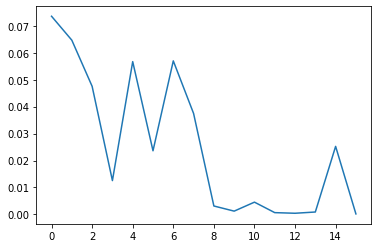

CPU times: user 4min 58s, sys: 1.92 s, total: 4min 59s
Wall time: 4min 59s


In [28]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 16

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()

    outputs = net(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    loss_arr.append(loss.item())
  
  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))
  
plt.plot(loss_epoch_arr)
plt.show()


We have got final Test Accuracy= 98.88, and Train Accuracy = 99.92. Let's plot confusion matrix to see how well we are doing on individual classes

In [31]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1



''

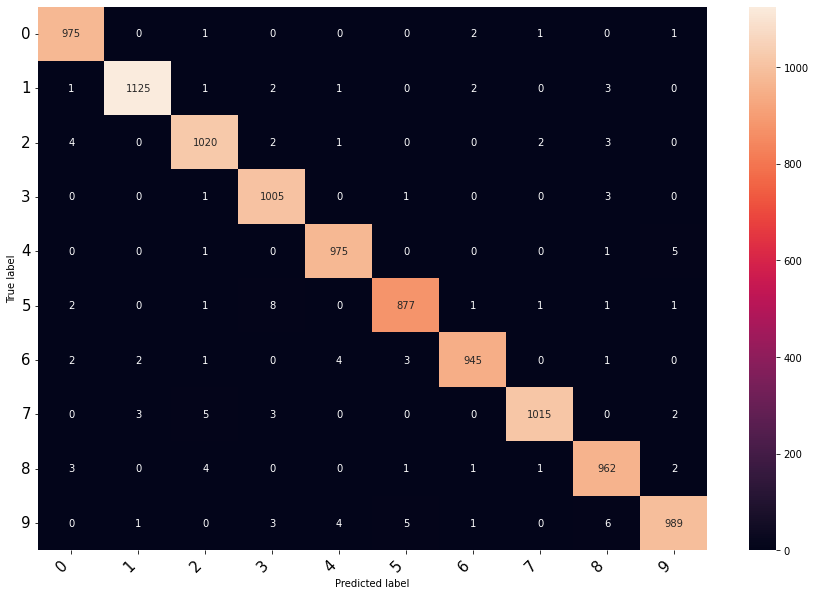

In [32]:
plt.figure(figsize=(15,10))

class_names = list(classes)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;

We have per-class accuracies:

In [33]:
class_accuracy=100*confusion_matrix.diagonal()/confusion_matrix.sum(1)
print(class_accuracy)

tensor([99.4898, 99.1189, 98.8372, 99.5050, 99.2872, 98.3184, 98.6430, 98.7354,
        98.7680, 98.0178])
